# EXTRA: output playground

Here's a fun little janky treat that I threw together mostly for fun, but I think there are intuitions that can be gained from it.

This is a stable diffusion playground that connects to your google drive, and lets you save your stable diffusion outputs as gifs! If you run this script and give it access to your google drive, it'll let you save an animated gif of your noisy output and denoised output slowly turning into a final image, as well as your inputs to generate your specific outputs. These will all go into separate folders in an SD_outputs/ folder in your google drive.

The easiest way to run this is to hit 'Runtime'>'Run all' or Ctrl+F9, which will automatically run everything, and then save our default output (An astronaut on a horse) into your google drive. Then, you can iterate in section 2, where it says, in big bold letters, 'ITERATE HERE'.

Another note, you should probably run this on a GPU instance of colab (a T4 instance), which you can select in the top-right corner of the colab UI, with a little drop down arrow. It *should* still work on a CPU instance, but it'll be much much slower. You can also run this locally, you'll just have to remove the google drive mounting code, and change the directory variables accordingly.

There's also an input for injecting image latents into the denoising process. If you want to put in your own sketches which you need a link for, I suggest [sketchpad.io](https://sketch.io/sketchpad/).

**NOTE:** If you would like to save your outputs, you *MUST* accept permissions from google drive after running the second cell of this notebook below. If you wouldn't like to do so and do not wish to give permissions to Google, simply comment out the section of code under `# Mounting Google Drive`, and never run the `save_output()` function (although if you do that, you will not be able to view the animated gifs that show how your output was generated.)

Happy generating!

In [6]:
!pip install diffusers

Defaulting to user installation because normal site-packages is not writeable


In [6]:
from PIL import Image
from tqdm.auto import tqdm
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from torchvision import transforms

from typing import Callable
import numpy as np

from io import BytesIO
import requests
from torchvision import transforms as tfms

import json

torch_device = "cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu")

torch_dtype = torch.float16 if torch_device in ["cuda", "mps"] else torch.float32

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

#4. the schedule algorithm used to "renoise" the image
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# moving to GPU and halving precision for inference speed.
vae = vae.to(device = torch_device, dtype = torch_dtype)
text_encoder = text_encoder.to(device = torch_device, dtype = torch_dtype)
unet = unet.to(device = torch_device, dtype = torch_dtype)

# Mounting Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# import os

# if not os.path.isdir('/content/drive/MyDrive/SD_outputs'):
#   os.makedirs('/content/drive/MyDrive/SD_outputs')

# output_dir='/content/drive/MyDrive/SD_outputs/'

#define embedding generation function for downstream use - this
def text_embedder(texts_list):
    text_input = tokenizer(texts_list, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    # text_embeddings=text_embeddings.sum(dim=0).reshape([1,77,768])
    # text_embeddings=text_embeddings/len(texts_list)
    return text_embeddings

#define image import function, for downstream use

def img2VAETensor(PILImage):
    """Converts an image into a VAE input"""
    PILImage = PILImage.convert('RGB')
    ImgTensor = tfms.ToTensor()(PILImage).unsqueeze(0) * 2.0 - 1.0
    return ImgTensor

def VAE_encode(VAETensor):
    """Encode an image tensor into the latent VAE space"""
    init_encode = vae.encode(VAETensor)
    # This magic number is a scaling factor empirically determined by the original authors of the Stable Diffusion model.
    # Roughly speaking, it compensates for the variation they found in the training image data latent tensors - effectively
    # normalizing the data so that it has slightly better computational performance
    encoded_sample = init_encode.latent_dist.sample() * 0.18215
    return encoded_sample

def encode_img(URL):
    """does VAE encoding of img from URL"""
    ImgURL = requests.get(URL)
    Img = Image.open(BytesIO(ImgURL.content))
    
    lrdiff=Img.size[0]-min(Img.size)
    tbdiff=Img.size[1]-min(Img.size)
    Img = Img.crop((0,0,Img.size[0]-lrdiff, Img.size[1]-tbdiff))
    Img = Img.resize((512,512))

    tensor_Img=img2VAETensor(Img).to(device = torch_device, dtype = torch_dtype)
    encodedSample=VAE_encode(tensor_Img)

    return encodedSample

def injection_image2latent(URL):
    injection=Image.open(image_str)
    injection=injection.resize((64,64))
    injection=injection.convert("RGBA")
    transform = transforms.Compose([
    transforms.PILToTensor()
        ])

    injectLatent=transform(injection).numpy()
    injectLatent=injectLatent.astype("float16")/255
    injectLatent=torch.Tensor(injectLatent).half()
    injectLatent=injectLatent.reshape([1,4,64,64]).to(device = torch_device, dtype = torch_dtype)

    with torch.no_grad():
        noise_pred = unet(injectLatent, scheduler.init_noise_sigma, encoder_hidden_states=uncond_embeddings).sample

    latents = scheduler.step(noise_pred, scheduler.init_noise_sigma, injectLatent).prev_sample

    return latents


def latents2img(latents):
    latents = 1 / 0.18215 * latents
    latents = latents.half()
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    # print(images.shape)
    pil_images = [Image.fromarray(image) for image in images]

    pil_images[0]
    return pil_images[0]

def embedding_tfms(text_embeddings, text_input_weights: list[float] = None, text_input_tfm: Callable = None):
    num_embeddings = text_embeddings.shape[0]
    if text_input_weights is not None:
        assert num_embeddings == len(text_input_weights), \
            f"your text input wieghts and text input length do not match up. text_inputs: {num_embeddings}, weights: {len(text_input_weights)}"
        for i in range(text_embeddings.shape[0]):
            text_embeddings[i]=text_embeddings[i]*text_input_weights[i]
        text_embeddings=text_embeddings.sum(dim=0).reshape([1,77,768])
    else:
        text_embeddings=text_embeddings.sum(dim=0).reshape([1,77,768])
        text_embeddings=text_embeddings/num_embeddings  
    if text_input_tfm is not None:
        text_embeddings = text_input_tfm(text_embeddings)
    return text_embeddings

#function for image generation
def StableDiffusion(text_input: list[str], 
                    height: int, 
                    width: int, 
                    num_inference_steps: int, 
                    guidance_scale: float, 
                    seed: int, 
                    uncond_input: list[str] = None, 
                    image_inject: tuple[str, int] = None,
                    text_input_weights: list = None,
                    text_input_tfm: Callable = None,
                    uncond_input_weights: list = None,
                    uncond_input_tfm: Callable = None):
    
    text_embeddings = text_embedder(text_input)
    if uncond_input is not None:
        uncond_embeddings = text_embedder(uncond_input)
    else:
        uncond_embeddings = text_embedder([''])

    # TEXT INPUT TRANSFORMS
    text_embeddings = embedding_tfms(text_embeddings, text_input_weights, text_input_tfm)
    uncond_embeddings = embedding_tfms(uncond_embeddings, uncond_input_weights, uncond_input_tfm)

    batch_size=1

    generator=torch.manual_seed(seed)

    if not image_inject or image_inject[1]!=0:
        latents = torch.randn(
            (batch_size, unet.config.in_channels, height // 8, width // 8),
            generator=generator,
        ).to(device = torch_device, dtype = torch_dtype)
    else:
        inject_latents=encode_img(image_inject[0])
        noise = torch.randn(
            (batch_size, unet.config.in_channels, height // 8, width // 8),
            generator=generator,
        ).to(device = torch_device, dtype = torch_dtype)
        latents = scheduler.add_noise(inject_latents, noise, scheduler.timesteps[0].unsqueeze(0))

    latents = latents.to(device = torch_device, dtype = torch_dtype)

    latents = latents * scheduler.init_noise_sigma

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    scheduler.set_timesteps(num_inference_steps)

    noisy_outputs_list=[]
    clean_outputs_list=[]
    current_step = 0
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        
        if image_inject is not None:
            if image_inject[1]==current_step:
                inject_latents=encode_img(image_inject[0])
                noise = torch.randn(
                    (batch_size, unet.config.in_channels, height // 8, width // 8), 
                    generator=generator,
                ).to(device = torch_device, dtype = torch_dtype)
                latents = scheduler.add_noise(inject_latents, noise, t.unsqueeze(0))

        
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t).half()

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        all_latents = scheduler.step(noise_pred, t, latents)
        clean_latents = all_latents.pred_original_sample
        latents = all_latents.prev_sample
        #save intermediate decoded outputs, for viewing pleasure
        noisy_outputs_list.append(latents2img(latents))
        clean_outputs_list.append(latents2img(clean_latents))
        current_step += 1

    input_dict={'text_input': text_input,
                'text_input_weights': text_input_weights,
                'text_input_tfm': text_input_tfm,
                'uncond_input': uncond_input,
                'uncond_input_weights': uncond_input_weights,
                'uncond_input_tfm': uncond_input_tfm,
                'height': height,
                'width': width,
                'num_inference_steps': num_inference_steps,
                'guidance_scale': guidance_scale,
                'seed': seed,
                'image_inject': image_inject}

    return (noisy_outputs_list, clean_outputs_list, input_dict)


# SAVE OUTPUTS

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def save_outputs(output, dir):
    name = '--'.join(output[2]['text_input'])+'_'+str(output[2]['seed'])
    savedir=dir + name + '/'
    if not os.path.isdir(savedir):
      os.mkdir(savedir)
    output[0][0].save(savedir + 'noisy_output.gif',save_all=True, append_images=output[0][1:], optimize=False, duration=1, loop=0)
    output[1][0].save(savedir + 'clean_output.gif',save_all=True, append_images=output[1][1:], optimize=False, duration=1, loop=0)
    combined = []
    for i in range(len(output[0])):
        combined.append(image_grid([output[0][i],output[1][i],output[0][i]], 1, 3))
        combined.append(image_grid([output[0][i],output[1][i],output[1][i]], 1, 3))
    combined[0].save(savedir + 'combined_output.gif',save_all=True, append_images=combined[1:], optimize=False, duration=1, loop=0)
    with open(savedir+"inputs.json", "w") as writefile:
      json.dump(output[2], writefile)


## TOY FUNCTIONS

# generate random sentence out of tokens

def gen_rand_sentence(seed: int = None):
    tokenlist = list(range(49408))
    if seed is not None:
        np.random.seed(seed)
    randtokenlist = np.random.choice(tokenlist, size=77, replace=True)
    return ' '.join(tokenizer.batch_decode(randtokenlist))

# ITERATE HERE

You pretty much only have to play around with the inputs here to interact with this playground. Here's a quick bit of documentation on each of these inputs:

- **text_input:** list[str] - A list of string inputs for guided image generation (i.e. the sentence you use to generate an image with stable diffusion). If putting in more than one string, the embeddings generated by each item in the list are either summed up based on the weights listed in `text_input_weights`, or no weights are given, the embeddings are averaged by default.
- **text_input_weights:** list[float] *Optional* - a list of weights given to each of the embeddings generated from the list in `text_input`. Can be any valid float number, although some values might cause issues with the final generation (play around and find out yourself!) MUST be the same length as the `text_input` list.
- **text_input_tfm:** Callable *Optional* - allows you to input an arbitrarily defined function that returns a transformation of a single embedding to transform the summed embeddings from `text_input`. If none given, no transformations are applied to the text embedding.
- **uncond_input:** list[str] *Optional* - A list of string inputs for the unconditioned input, used in classifier-free guidance to steer generation away from this input. If no inputs given, defaults to `['']`. If putting in more than one string, the embeddings generated by each item in the list are either summed up based on the weights listed in `uncond_input_weights`, or no weights are given, the embeddings are averaged by default.
- **uncond_input_weights:** list[float] *Optional* - a list of weights given to each of the embeddings generated from the list in `uncond_input`. Can be any valid float number, although some values might cause issues with the final generation (play around and find out yourself!) MUST be the same length as the `uncond_input` list.
- **uncond_input_tfm:** Callable *Optional* - allows you to input an arbitrarily defined function that returns a transformation of a single embedding to transform the summed embeddings from `uncond_input`. If none given, no transformations are applied to the text embedding.
- **height:** int - height in pixels of the final output
- **width:** int - width in pixels of the final output
- **num_inference_steps:** int - number of denoising steps used to generate output
- **guidance_scale:** float - scale to which a generation based on `text_input` is guided *away* from `uncond_input`. Higher values here move `text_input` guidance further away from `uncond_input`.
- **seed:** int - the random seed used to generate the noise pattern which initialises the diffusion process. Also dictates the noise pattern added to the `image_inject` latents
- **image_inject:** tuple[str, int] *Optional* - Optional tuple input that injects an image pulled from the URL (the first string object in tuple) into the generation process, at the step indicated in the second integer-object in the tuple. e.g., if `image_inject` = ('www.example.com', 10), then the image from www.example.com would be injected into the generation process at the 10th step (although technically 11th since we're using 0 as our first index, like a sane computer scientist would).

---

I have also written up a function called `gen_rand_sentence()` which will generate a sentence that is 77 tokens long, that is a completely random selection of tokens from the CLIP tokenizer. It spits out garbage, which is funny, and you can use that as an input into either the `text_input`, the `uncond_input`, or both! 

If you would like to save your outputs, simply run the `save_outputs()` cell below. No need to alter anything - your output will automatically save to your Google Drive under SD_outputs, into a folder named by your `text_input` and `seed` input variables!

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


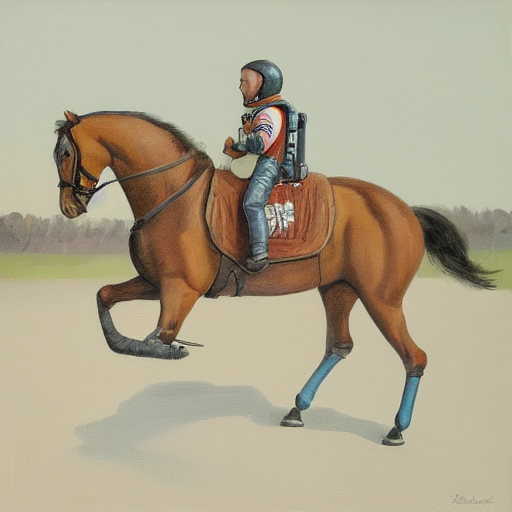

In [7]:
output=StableDiffusion(
    #text inputs
    text_input=['astronaut on a horse'],
    text_input_weights = None,
    text_input_tfm = None,
    #unconditioned inputs
    uncond_input=[''],
    uncond_input_weights = None,
    uncond_input_tfm = None,
    #output image dimensions
    height=512,
    width=512,
    #number of inference steps
    num_inference_steps=50,
    #guidance scale
    guidance_scale=7.5,
    #seed
    seed=9001,
    image_inject=('https://i.pinimg.com/736x/05/d8/d7/05d8d76ecda112f15493b181374d331e.jpg', 15)
)

output[1][-1]

In [ ]:
#if you like it - save the outputs here. NOTE: YOUR OUTPUTS WILL OVERWRITE IF YOU HAVEN'T CHANGED THE TEXT_INPUT AND/OR SEED VARIABLES.
save_outputs(output, output_dir)